开始处理鲜样本文件...
正在读取文件: /home/zhanxiaojuan/data1/zhanxiaojuan/PRCA033509/read_length_distribution/FF/mixcr/7-ZXH_LC.part_000.mixcr_align.4667.fastq
文件 7-ZXH_LC.part_000.mixcr_align.4667.fastq 总read数: 4667
过滤离群值后的read数: 4667
开始处理FFPE样本文件...
正在读取文件: /home/zhanxiaojuan/data1/zhanxiaojuan/PRCA033509/read_length_distribution/FFPE/mixcr/FFPE.mixcr_align.fastq
文件 FFPE.mixcr_align.fastq 总read数: 4667
过滤离群值后的read数: 4667
图像已保存为: sample_comparison.pdf


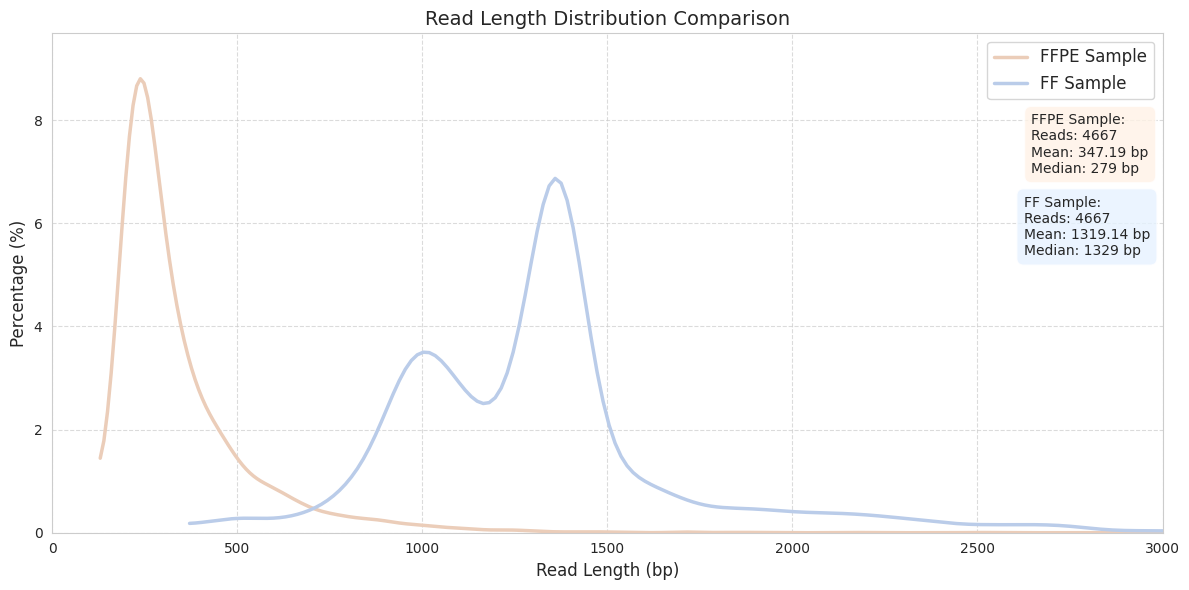

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from Bio import SeqIO
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import make_interp_spline

# 设置绘图风格
sns.set_style("whitegrid")
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

# 文件路径
# 鲜样本数据
ff_file = "/home/zhanxiaojuan/data1/zhanxiaojuan/PRCA033509/read_length_distribution/FF/mixcr/7-ZXH_LC.part_000.mixcr_align.4667.fastq"
# FFPE样本数据
ffpe_file = "/home/zhanxiaojuan/data1/zhanxiaojuan/PRCA033509/read_length_distribution/FFPE/mixcr/FFPE.mixcr_align.fastq"

# 定义一个函数来处理FASTQ文件并返回平滑后的曲线数据
def process_fastq_file(file_path, outlier_threshold=30000):
    # 存储每个read的长度
    read_lengths = []
    
    # 读取FASTQ文件并计算每个read的长度
    print(f"正在读取文件: {file_path}")
    try:
        # 使用普通文件打开方式，而不是gzip
        with open(file_path, "rt") as handle:
            for record in SeqIO.parse(handle, "fastq"):
                read_lengths.append(len(record.seq))
        
        # 计算总read数
        total_reads = len(read_lengths)
        print(f"文件 {file_path.split('/')[-1]} 总read数: {total_reads}")
        
        # 计算基本统计信息
        mean_length = np.mean(read_lengths)
        median_length = np.median(read_lengths)
        std_dev = np.std(read_lengths)
        
        # 过滤离群值
        filtered_lengths = [length for length in read_lengths if length <= outlier_threshold]
        print(f"过滤离群值后的read数: {len(filtered_lengths)}")
        
        # 创建直方图数据
        counts, bins = np.histogram(filtered_lengths, bins=150)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        percentages = counts / total_reads * 100
        
        # 平滑处理
        # 第一步：使用高斯滤波平滑数据
        smoothed_percentages = gaussian_filter1d(percentages, sigma=2)
        
        # 第二步：使用样条插值创建更平滑的曲线
        x_smooth = np.linspace(min(bin_centers), max(bin_centers), 300)
        spl = make_interp_spline(bin_centers, smoothed_percentages, k=3)  # k=3 为三次样条
        y_smooth = spl(x_smooth)
        
        # 确保没有负值（插值可能产生少量负值）
        y_smooth = np.maximum(y_smooth, 0)
        
        return {
            'x_smooth': x_smooth,
            'y_smooth': y_smooth,
            'stats': {
                'total_reads': total_reads,
                'mean_length': mean_length,
                'median_length': median_length,
                'std_dev': std_dev
            }
        }
    except Exception as e:
        print(f"处理文件 {file_path} 时出错: {e}")
        return None

# 处理文件
print("开始处理鲜样本文件...")
ff_data = process_fastq_file(ff_file)
print("开始处理FFPE样本文件...")
ffpe_data = process_fastq_file(ffpe_file)

# 创建图像
plt.figure(figsize=(12, 6))

# 绘制曲线
plt.plot(ffpe_data['x_smooth'], ffpe_data['y_smooth'], 
         linewidth=2.5, color='#ebcdb9', linestyle='-', label='FFPE Sample')
plt.plot(ff_data['x_smooth'], ff_data['y_smooth'], 
         linewidth=2.5, color='#bacce9', linestyle='-', label='FF Sample')

# 添加网格线，使图表更易读
plt.grid(True, linestyle='--', alpha=0.7)

# 设置图表标题和轴标签
plt.title('Read Length Distribution Comparison', fontsize=14)
plt.xlabel('Read Length (bp)', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)

# 添加图例
plt.legend(fontsize=12, loc='upper right')

# 设置x轴和y轴的范围
plt.xlim(0, 3000)
y_max = max(max(ff_data['y_smooth']), max(ffpe_data['y_smooth']))
plt.ylim(0, y_max * 1.1)  # 给y轴顶部留出10%的空间

# 在图上添加统计信息
ff_info = f"FF Sample:\n" \
           f"Reads: {ff_data['stats']['total_reads']}\n" \
           f"Mean: {ff_data['stats']['mean_length']:.2f} bp\n" \
           f"Median: {ff_data['stats']['median_length']:.0f} bp"

ffpe_info = f"FFPE Sample:\n" \
            f"Reads: {ffpe_data['stats']['total_reads']}\n" \
            f"Mean: {ffpe_data['stats']['mean_length']:.2f} bp\n" \
            f"Median: {ffpe_data['stats']['median_length']:.0f} bp"

# 将FF样本信息放在右上角
plt.annotate(ff_info, xy=(0.875, 0.675), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.5", facecolor="#e6f2ff", alpha=0.8),
             verticalalignment='top')

# 将FFPE信息放在右上角
plt.annotate(ffpe_info, xy=(0.882, 0.84), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.5", facecolor="#fff2e6", alpha=0.8),
             verticalalignment='top')

# 优化布局
plt.tight_layout()

# 保存图像
output_file = "sample_comparison.pdf"
plt.savefig(output_file, dpi=600, bbox_inches='tight')
print(f"图像已保存为: {output_file}")

# 显示图像
plt.show()